In [1]:
# PTT title generator from content base on seq2seq model.
import pandas as pd
import numpy as np
import csv
import os
import types 

#Initialize for files name and path.
base_dir = 'C:/Users/User/Raw data/PTT'
totalboard_name = 'TJ-BG-AT-SX-CC-MV'
board_name = ['Tech_job','Boy-Girl','AllTogether','sex','C_Chat','movie']
board_dict_index = {'Tech_job':0,'Boy-Girl':1,'AllTogether':2,'sex':3,'C_Chat':4,'movie':5}

max_word_length = 256
min_word_length = 100
max_title_length = 20
words_limit = 60000
label_newnum = len(board_name)

GO_id = '<GO>' #解碼器端的句子起始標識符。
EOS_id = '<EOS>' #解碼器端的句子結束標識符。
UNK_id = '<UNK>' #低頻詞或者一些未遇到過的詞等。
PAD_id = '<PAD>' #補全字符。

new_content_dir = []
totalboard_dir = os.path.join(base_dir, totalboard_name)
if not os.path.exists(totalboard_dir):
    os.makedirs(totalboard_dir)
for name_ind in range(len(board_name)):
    # New data path
    new_content_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_content'))
    if not os.path.exists(new_content_dir[name_ind]):
        os.makedirs(new_content_dir[name_ind])

In [1]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import jieba
import json

# Import dictionary fron jieba and PTT.
jieba.set_dictionary('C:/Users/User/Anaconda3/Lib/site-packages/jieba/dict.txt.big')
jieba.load_userdict('C:/Users/User/Anaconda3/Lib/site-packages/jieba/userdict.txt')

text_content = []
text_label = []
text_generator = []

# Load PTT content and information.
dfs_total = pd.read_csv(os.path.join(totalboard_dir, totalboard_name + '.csv'))
len_total = len(dfs_total)

for dfs_index in range(len_total):
    read_index = int(dfs_total.iloc[dfs_index, 0])
    type_name = str(dfs_total.iloc[dfs_index, 1])
    word_length = int(dfs_total.iloc[dfs_index, 5])
    title_name = str(dfs_total.iloc[dfs_index, 9])
    this_board_name = str(dfs_total.iloc[dfs_index, 10])
    
    # Add start and end character.
    text = GO_id + ' '
    with open(os.path.join(new_content_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            for row in rows:
                # Read content and remove empty.
                text = text + row#.lower()
        else:
            text = text + ' ' + EOS_id
    
    # Split titles to words by Jieba.
    title_name.encode('utf-8-sig')
    title_jieba = jieba.cut(title_name, cut_all=False)
    title_name = GO_id
    word_length = 0
    for word in title_jieba:
        word_length += 1
        title_name = title_name + ' ' + word#.lower()
    else:
        title_name = title_name + ' ' + EOS_id

    text_content.append(text)
    text_label.append(board_dict_index[this_board_name])
    text_generator.append(title_name)
    file.close()

# Build vocabulary and convert content to sequence by Keras tool.
tokenizer = Tokenizer(num_words=words_limit, 
                      filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n　，。！：；、？﹝﹞「」『』（）｛｝［］【】《》“”‘’＼｜〝〞‵′＋－＊／＝≦≧＿＠＃＄％︿＆～§◎．※ㄧ↔│○●☆★◇◆□■▽▼△▲㊣⊙⊕ˍ…﹌﹋﹎﹍﹉﹊‥–↑↓←→↖↗↙↘∥∕℅≒≡∩∪∞￣＿◤◥◣◢∵∴〒⊥∠⊿┼┴┬┤├▔─│▕┌┐└┘╭╮╰╯═╞╪╡╔╦╗╠╬╣╚╩╝╒╤╕╘╧╛╓╥╖╟╫╢╙╨╜║▓╱╲╳▁▂▄▅▆▇█▏▎▍▌▋▊▉▁▔', 
                      lower=False,
                      split=" ")
                      #oov_token=UNK_word)
tokenizer.fit_on_texts(text_content+text_generator)
vocab_sort = tokenizer.word_index
vocab_counts = tokenizer.word_counts
vocab_docs = tokenizer.word_docs

with open(os.path.join(totalboard_dir, 'vocab_sort.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_sort))
with open(os.path.join(totalboard_dir, 'vocab_counts.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_counts))
with open(os.path.join(totalboard_dir, 'vocab_docs.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_docs))
with open(os.path.join(totalboard_dir, 'vocab.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab))
with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_reverse))

print('Vocabulary size after jieba: ', len(vocab_sort))
vocab = {}
vocab_reverse = {}
vocab_keys = list(vocab_sort.keys())
for vocab_word in vocab_keys:
    vocab_index = vocab_sort[vocab_word]
    if vocab_index <= words_limit+2:
        vocab_reverse[vocab_index] = vocab_keys[vocab_index-1]
        vocab[vocab_keys[vocab_index-1]] = vocab_index
        if vocab_index % 1000 == 0 or vocab_index < 20:
            print(vocab[vocab_word], vocab_word, vocab_reverse[vocab_index], 
                  vocab_counts[vocab_word], vocab_docs[vocab_word])
else:
    #vocab[GO_id] = words_limit + 1
    #vocab_reverse[words_limit + 1] = GO_id
    #vocab[EOS_id] = words_limit + 2
    #vocab_reverse[words_limit + 2] = EOS_id
    vocab[UNK_id] = words_limit + 3
    vocab_reverse[words_limit + 3] = UNK_id

# 將單字轉換成字庫的索引值
total_content_word_ids = tokenizer.texts_to_sequences(text_content+text_generator)
total_content_size = [len(word_ids) for word_ids in total_content_word_ids]

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Building prefix dict from C:\Users\User\Anaconda3\Lib\site-packages\jieba\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.ufa6ae29b0cbce8b45e006c7fa30eaaf8.cache
Loading model cost 1.052 seconds.
Prefix dict has been built succesfully.


Vocabulary size after jieba:  199065
1 的 的 481258 108953
2 我 我 188313 60362
3 <GO> <GO> 172800 172800
4 <EOS> <EOS> 172800 172800
5 是 是 159030 69314
6 了 了 131069 60883
7 有 有 108453 60010
8 在 在 96899 54569
9 也 也 87639 49369
10 都 都 75809 45480
11 就 就 71686 42483
12 不 不 67015 43479
13 很 很 55221 35161
14 會 會 55175 36785
15 他 他 50946 20397
16 看 看 49727 30798
17 你 你 49044 22078
18 跟 跟 48592 31670
19 想 想 48063 34426
1000 手槍 手槍 1255 936
2000 得知 得知 609 582
3000 篇文章 篇文章 363 345
4000 失業 失業 255 219
5000 紳士 紳士 193 166
6000 東區 東區 153 147
7000 支出 支出 125 97
8000 碎 碎 105 93
9000 發光 發光 90 81
10000 異星 異星 78 76
11000 同期 同期 68 63
12000 參戰 參戰 61 54
13000 不聊 不聊 54 54
14000 國慶 國慶 49 46
15000 半殘 半殘 44 43
16000 顯著 顯著 40 40
17000 紛紛表示 紛紛表示 37 37
18000 米蟲 米蟲 34 34
19000 網誌 網誌 32 31
20000 閔 閔 29 29
21000 跳繩 跳繩 27 18
22000 東東 東東 26 22
23000 身份證 身份證 24 20
24000 何能 何能 23 23
25000 rule rule 21 15
26000 馬鈴薯 馬鈴薯 20 19
27000 靜脈 靜脈 19 19
28000 捫心自問 捫心自問 18 17
29000 以下內容 以下內容 17 17
30000 衝出去 衝出去 16 16
31000 保健室 保健室 16 11
3

In [13]:
skip_window = 1 # How many words to consider left and right.
num_skips = 2*skip_window # How many times to reuse an input to generate a context.
sample_threshold = 0.0002

def sampling_rate(sample_num, total_num, sample_threshold):
    z_rate = sample_num/total_num/sample_threshold
    return min((np.sqrt(z_rate) + 1.0)/z_rate, 1.0)

def context_word_size(content_size, skip_window):
    return content_size * skip_window * 2

total_context_size = [context_word_size(word_ids,skip_window) for word_ids in total_content_size]
sum_context_size = sum(total_context_size)
print('Sum over all context size: ',sum_context_size)

sum_vocab_counts = 0
unk_count = 0
for vocab_word in vocab_sort:
    vocab_index = vocab_sort[vocab_word]
    sum_vocab_counts += vocab_counts[vocab_word]
    if vocab_index > words_limit+2:
        unk_count += vocab_counts[vocab_word]
print('Sum over all vocabulary counts: ',sum_vocab_counts)

vocab_rate = {}
for vocab_word in vocab:
    vocab_index = vocab[vocab_word]
    if vocab_index <= words_limit+2:
        vocab_rate[vocab_index] = sampling_rate(vocab_counts[vocab_word], 
                                        sum_vocab_counts, sample_threshold)
    else:
        assert vocab_word == UNK_id
        vocab_rate[vocab_index] = sampling_rate(unk_count, 
                             sum_vocab_counts, sample_threshold)
        break

def generate_context(content_ids, content_size, skip_window):
    context_size = context_word_size(content_size, skip_window)
    inputs = np.ndarray(shape=(context_size), dtype=np.int32)
    labels = np.ndarray(shape=(context_size, 1), dtype=np.int32)
    for i in range(content_size):
        for j in range(skip_window):
            inputs[(i*skip_window+j)*2] = content_ids[i]
            inputs[(i*skip_window+j)*2+1] = content_ids[i]
            if i-j-1>=0:
                labels[(i*skip_window+j)*2] = content_ids[i-j-1]
            else:
                labels[(i*skip_window+j)*2] = 0
            if i+j+1<content_size:
                labels[(i*skip_window+j)*2+1] = content_ids[i+j+1]
            else:
                labels[(i*skip_window+j)*2+1] = 0
    return inputs, labels

total_inputs = np.ndarray(shape=(sum_context_size), dtype=np.int32)
total_labels = np.ndarray(shape=(sum_context_size, 1), dtype=np.int32)
context_index = 0
for word_ids, word_size in zip(total_content_word_ids, total_content_size):
    inputs, labels = generate_context(word_ids, word_size, skip_window)
    context_size = context_word_size(word_size, skip_window)
    total_inputs[context_index:context_index+context_size] = inputs
    total_labels[context_index:context_index+context_size,:] = labels
    context_index += context_size
else:
    assert context_index == sum_context_size
    
np.minimum(total_inputs, words_limit + 3, total_inputs)
np.minimum(total_labels, words_limit + 3, total_labels)

Sum over all context size:  20667416
Sum over all vocabulary counts:  10626889


array([[  0],
       [ 45],
       [  3],
       ...,
       [  4],
       [552],
       [  0]])

In [14]:
import tensorflow as tf
import time

patience = 0
num_epoch = 50
batch_size = 128
embedding_size = 300 # Dimension of the embedding vector.
w2v_lr = 0.1
exp_decay_rate = 0.8
vocab_size = len(vocab)
num_instances = sum_context_size
iter_per_epoch = num_instances // batch_size

exp_decay_steps = sum_context_size // batch_size
similar_nn_num = 8 # number of nearest neighbors

valid_examples = np.array([vocab[GO_id],vocab[EOS_id],vocab['我'],vocab['台灣'],
                           vocab['喜歡'],vocab['可以'],vocab['動畫'],vocab['電影'],
                           vocab['工作'],vocab['時間'],vocab['朋友'],vocab['閃光']])
valid_size = valid_examples.size
number_sampled = 10 # Number of negative examples to sample.

def word2vector_model():
    train_inputs = tf.placeholder(tf.int32, shape=[None], name='train_inputs')
    train_labels = tf.placeholder(tf.int32, shape=[None, 1], name='train_labels')
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                             name='embeddings')
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    # Construct the variables for the softmax
    nce_weights = tf.Variable(tf.truncated_normal([vocab_size, embedding_size],
                                                  stddev=1.0 / np.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocab_size]))
    
    # Compute the NCE loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_sampled=number_sampled,
                                         num_classes=vocab_size),
                         name='nce_cost')
    # We use the SGD optimizer.
    global_step = tf.Variable(0, trainable=False)
    dynam_w2v_lr = tf.train.exponential_decay(w2v_lr, global_step, exp_decay_steps, 
                                                           exp_decay_rate, staircase=False)
    global_step = global_step + 1
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=dynam_w2v_lr).minimize(loss, 
                                                name='optimizer')
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings), 
                           name='valid_embeddings')
    return train_inputs, train_labels, loss, optimizer, similarity, normalized_embeddings
    
################################################################
# Prepare to run session
################################################################
total_start_t = time.time()
build_new_model = 1
if build_new_model:
    str_epoch = 0
    model_name = 'PTT_Words_Embedding_' + str(total_start_t)
else:
    str_epoch = 50
    model_name = 'PTT_Words_Embedding_1523412734.9787965'
    mdl_dir = os.path.join(base_dir, 'model')
    if not os.path.exists(mdl_dir):
        os.makedirs(mdl_dir)
    model_dir = os.path.join(mdl_dir, model_name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

iter_pct10 = num_instances // 10
if (num_instances % batch_size) > 0:
    iter_per_epoch += 1

best_validation_loss = 0.0
early_stop_counter = 0

################################################################
# Run model session
################################################################
word2vector_graph = tf.Graph()
if build_new_model:
    ######## Build model parameters ########
    with word2vector_graph.as_default():
        train_inputs, train_labels, cost, optimizer, similarity, normalized_embeddings = word2vector_model()

with tf.Session(graph=word2vector_graph) as sess:
    if build_new_model:
        sess.run(tf.global_variables_initializer())
        best_epoch = 1
    else:
        ######## Load model parameters ########
        # Load model and weight parameters
        best_epoch = str_epoch
        load_model_dir = os.path.join(model_dir, 'model-{}'.format(str_epoch))
        loader = tf.train.import_meta_graph(load_model_dir + '.meta')
        loader.restore(sess, load_model_dir)
        # Load named input parameters
        train_inputs = word2vector_graph.get_tensor_by_name('train_inputs:0')
        train_labels = word2vector_graph.get_tensor_by_name('train_labels:0')
        loss = word2vector_graph.get_tensor_by_name('nce_cost')
        #similarity = 
        #normalized_embeddings = 
        optimizer = word2vector_graph.get_operation_by_name('optimizer')
        
    ######## Run model epoch ########
    for e in range(str_epoch,str_epoch+num_epoch):
        rand_idxs = np.random.permutation(num_instances)
        print('\n========')
        print('epoch' + str(e+1))
        print('========')
        start_t = time.time()
        
        ######## Get random input batch and training model. ########
        batch_counts = 0
        iter_count = 0
        X_batch = []
        Y_batch = []
        for i in range(num_instances):
            rand_input = total_inputs[rand_idxs[i]]
            rand_label = total_labels[rand_idxs[i]]
            vocab_rand = np.random.uniform(0.0, 1.0)
            if rand_label!=0 and vocab_rand < vocab_rate[rand_input]:
                X_batch.append(rand_input)
                Y_batch.append(rand_label)
                batch_counts = (batch_counts + 1) % batch_size
                
                if batch_counts % batch_size == 0:
                    iter_count += 1
                    X_batch = np.array(X_batch)
                    Y_batch = np.array(Y_batch)
                    optimizer_op, loss = sess.run( [optimizer, cost],
                                        {train_inputs: X_batch, train_labels: Y_batch})
                    X_batch = []
                    Y_batch = []
                    if np.isnan(loss):
                        print('\n!!!! Loss is NaN! !!!!')
                        print('NaN epoch: ', e, ' ; NaN iteration: ', iter_count)
                        print('The last loss: ', last_loss)
                        print(optimizer_op)
                        print(last_optimizer_op)
                        break
                    else:
                        last_loss = loss
                        last_optimizer_op = optimizer_op
            
            if (i+1) % iter_pct10 == 0:
                print('Iteration ',iter_count,' (',round(i*100/num_instances,2),'%) Train Loss: ',
                      loss,'; run time[s]: ', time.time() - start_t,end='\n')
        
        ######## Generate title form testing content and validating model. ########
        sim = similarity.eval()
        for i in range(valid_size):
            valid_word = vocab_reverse[valid_examples[i]]
            nearest = (-sim[i, :]).argsort()[1:similar_nn_num+1]
            log = 'Nearest to %s:' % valid_word
            for k in range(similar_nn_num):
                close_word = vocab_reverse[nearest[k]]
                log = '%s %s,' % (log, close_word)
            print(log)
        
        ######## Save model weight parameters and information. ########
        if loss < best_validation_loss or e == 0:
            best_validation_loss = loss
            best_epoch = e
            early_stop_counter = 0
            print('Save best score!! ', best_validation_loss)
        else:
            early_stop_counter += 1
            print('Count early stop!! ', early_stop_counter)

        print('Elapsed time in epoch ', e+1, ': ', time.time() - start_t, 
              ' [s]: iteration number: ', iter_count)
        
        if e==0:
            mdl_dir = os.path.join(base_dir, 'model')
            if not os.path.exists(mdl_dir):
                os.makedirs(mdl_dir)
            model_dir = os.path.join(mdl_dir, model_name)
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)

        model_path = os.path.join(model_dir, 'model-%d' %(e+1))
        saver = tf.train.Saver()
        saver.save(sess, model_path)
        
        if patience != 0 and early_stop_counter >= patience:
            print('\n#######')
            print('Best model')
            print('#######')
            print('Stop by early stopping')
            print('Best score: ', best_validation_loss, 'Beat model: ', best_epoch)
            break
    normal_embeddings = normalized_embeddings.eval()

print('\nElapsed time in total: ' + str(time.time() - total_start_t))


epoch1
Iteration  11150  ( 10.0 %) Train Loss:  55.1228 ; run time[s]:  31.434449672698975
Iteration  22301  ( 20.0 %) Train Loss:  24.762634 ; run time[s]:  62.55535840988159
Iteration  33458  ( 30.0 %) Train Loss:  34.155006 ; run time[s]:  93.25156021118164
Iteration  44613  ( 40.0 %) Train Loss:  21.549812 ; run time[s]:  122.9575583934784
Iteration  55765  ( 50.0 %) Train Loss:  34.776485 ; run time[s]:  152.75527596473694
Iteration  66921  ( 60.0 %) Train Loss:  34.369766 ; run time[s]:  183.81676769256592
Iteration  78076  ( 70.0 %) Train Loss:  14.968432 ; run time[s]:  214.8852744102478
Iteration  89228  ( 80.0 %) Train Loss:  11.963154 ; run time[s]:  246.0892858505249
Iteration  100379  ( 90.0 %) Train Loss:  31.532284 ; run time[s]:  277.342497587204
Iteration  111534  ( 100.0 %) Train Loss:  22.83826 ; run time[s]:  308.4299919605255
Nearest to <GO>: 現在, 找, 說, 人, 9, 朋友, 怎麼, 吃,
Nearest to <EOS>: from, 面試, 請問, 人, >, 不, 好, 相處,
Nearest to 我: 問題, 有人, 知道, 我們, 人, 說, 現在, 你,
Neare

Iteration  78071  ( 70.0 %) Train Loss:  4.945107 ; run time[s]:  217.30354928970337
Iteration  89223  ( 80.0 %) Train Loss:  3.2777297 ; run time[s]:  248.75982856750488
Iteration  100382  ( 90.0 %) Train Loss:  4.9853244 ; run time[s]:  281.7468214035034
Iteration  111541  ( 100.0 %) Train Loss:  4.586526 ; run time[s]:  314.905312538147
Nearest to <GO>: 題, 9, 簽約, 自主, 現在, 剛剛, 真, 生活圈,
Nearest to <EOS>: from, >, Sent, 或是, Android, 作畫, 阿, 順路,
Nearest to 我: 有人, 我們, 你, 老闆, 有趣, 碩畢, 現在, 她,
Nearest to 台灣: 口頭, 這份, 她們, 繪圖, on, 日本, 程式, 168,
Nearest to 喜歡: 講話, 吃飯, 想, 騎, 得, 任職, 棒球, 想來,
Nearest to 可以: 一段時間, 可, 會, 技術員, 跟, 編輯, 願意, 天堂,
Nearest to 動畫: 另一半, 而已, 合, 一番, 很長, from, 當天, 日本,
Nearest to 電影: 平日, 運動, 反映, 時候, 數字, 人, 長度, 偶爾,
Nearest to 工作: 請教, 生產, 舒服, 狂, 渡過, 撥, 逛逛, 可能性,
Nearest to 時間: 我們, 信件, 05, 願意, 內容, 尾, 晚, 天人,
Nearest to 朋友: 認識, 神作, 妳, 男友, 片子, 說, 我們, 正在,
Nearest to 閃光: 報, 中途, 小辣椒, 功能, 設, 不住, 妻子, 如何,
Count early stop!!  1
Elapsed time in epoch  6 :  314.9554455280304  [s]: iteration number:  1


epoch12
Iteration  11152  ( 10.0 %) Train Loss:  3.4598649 ; run time[s]:  31.12380838394165
Iteration  22297  ( 20.0 %) Train Loss:  2.8812838 ; run time[s]:  62.4480836391449
Iteration  33447  ( 30.0 %) Train Loss:  2.4084842 ; run time[s]:  93.4004442691803
Iteration  44603  ( 40.0 %) Train Loss:  2.9252148 ; run time[s]:  124.43889498710632
Iteration  55750  ( 50.0 %) Train Loss:  3.7037554 ; run time[s]:  155.45937275886536
Iteration  66908  ( 60.0 %) Train Loss:  2.8710136 ; run time[s]:  186.65022134780884
Iteration  78049  ( 70.0 %) Train Loss:  3.2657652 ; run time[s]:  217.56657028198242
Iteration  89202  ( 80.0 %) Train Loss:  3.068423 ; run time[s]:  248.5733072757721
Iteration  100363  ( 90.0 %) Train Loss:  2.6055923 ; run time[s]:  279.73206639289856
Iteration  111514  ( 100.0 %) Train Loss:  2.6424794 ; run time[s]:  310.7143850326538
Nearest to <GO>: 題, 之銘言, 自主, 上個月, 鎖鏈, 卡卡, 9, 台東,
Nearest to <EOS>: Sent, >, 順路, from, 或是, 作畫, 的, 兩場,
Nearest to 我: 你, 我們, 有人, 她, 老闆, 他, 

Iteration  66929  ( 60.0 %) Train Loss:  2.4813037 ; run time[s]:  186.5683274269104
Iteration  78080  ( 70.0 %) Train Loss:  3.0915935 ; run time[s]:  217.48759198188782
Iteration  89235  ( 80.0 %) Train Loss:  2.7521791 ; run time[s]:  248.53826642036438
Iteration  100389  ( 90.0 %) Train Loss:  2.647838 ; run time[s]:  279.8508448600769
Iteration  111545  ( 100.0 %) Train Loss:  3.437394 ; run time[s]:  310.99075293540955
Nearest to <GO>: 題, 之銘言, 鎖鏈, 上個月, 台東, 卡卡, 腰間, 自主,
Nearest to <EOS>: Sent, >, 或是, 順路, 的, 兩場, 康復, 作畫,
Nearest to 我: 你, 他, 她, 我們, 有人, 老闆, 小弟, 活躍,
Nearest to 台灣: 日本, 一扇門, 童子軍, 小夜, 修正, 蜜雪兒, 這份, 監製,
Nearest to 喜歡: 講話, 愛意, 騎, 棒球, DJ, 流行樂, 裸露, 想,
Nearest to 可以: 能夠, 可, 能, 會, 一段時間, 願意, 才能, 行經,
Nearest to 動畫: 純純, 考核, 破表, 很長, 打擊樂, 另一半, 極大, 優良,
Nearest to 電影: 玻璃心, 反映, 小說, 自由自在, 來問, house, 科幻, twitch,
Nearest to 工作: 跟家裡, 渡過, 生產, 加班, 好太多, 可能性, 包養, 梁朝偉,
Nearest to 時間: 一億, 野人, 信件, 晚, 我們, 工時, 完畢, 見客,
Nearest to 朋友: 認識, 同事, 神作, 男友, 盤算, 30min, 高難度, 成果,
Nearest to 閃光: 小辣椒, 中途, 拉丁, 隨緣, 

Iteration  111533  ( 100.0 %) Train Loss:  2.4580922 ; run time[s]:  311.8636167049408
Nearest to <GO>: 題, 之銘言, 鎖鏈, 上個月, 腰間, 老婦, 台東, 兩槍,
Nearest to <EOS>: Sent, >, 或是, 的, 順路, 兩場, 慰勞, 康復,
Nearest to 我: 你, 他, 她, 我們, 小弟, 二者, 有人, 老闆,
Nearest to 台灣: 一扇門, 日本, 童子軍, 小夜, 監製, 修正, 蜜雪兒, 憋住,
Nearest to 喜歡: 講話, 愛意, 騎, 棒球, 流行樂, DJ, 想, 看環,
Nearest to 可以: 能夠, 能, 可, 會, 願意, 才能, 一段時間, 不能,
Nearest to 動畫: 打擊樂, 純純, 考核, 破表, 作品, 漫畫, 很長, 優良,
Nearest to 電影: 玻璃心, 小說, 自由自在, 反映, 科幻, 來問, twitch, house,
Nearest to 工作: 跟家裡, 加班, 生產, 渡過, 好太多, 很差, 包養, project,
Nearest to 時間: 一億, 野人, 晚, 見客, 信件, 工時, 西屯區, 完畢,
Nearest to 朋友: 認識, 同事, 男友, 盤算, 神作, 30min, 華電, 風化,
Nearest to 閃光: 小辣椒, 拉丁, 中途, 妻子, 才華, 隨緣, 設, 團滅,
Count early stop!!  1
Elapsed time in epoch  22 :  311.9147524833679  [s]: iteration number:  111533

epoch23
Iteration  11152  ( 10.0 %) Train Loss:  2.8007822 ; run time[s]:  31.283899784088135
Iteration  22298  ( 20.0 %) Train Loss:  2.3557088 ; run time[s]:  62.35144376754761
Iteration  33456  ( 30.0 %) Train Loss:  2.3


epoch28
Iteration  11157  ( 10.0 %) Train Loss:  2.3938057 ; run time[s]:  31.156933784484863
Iteration  22313  ( 20.0 %) Train Loss:  2.3490982 ; run time[s]:  62.26730680465698
Iteration  33467  ( 30.0 %) Train Loss:  2.448224 ; run time[s]:  93.33079981803894
Iteration  44621  ( 40.0 %) Train Loss:  2.4089665 ; run time[s]:  124.47756123542786
Iteration  55780  ( 50.0 %) Train Loss:  2.406426 ; run time[s]:  155.6762671470642
Iteration  66922  ( 60.0 %) Train Loss:  2.414102 ; run time[s]:  186.90729546546936
Iteration  78084  ( 70.0 %) Train Loss:  2.2277637 ; run time[s]:  218.07854628562927
Iteration  89229  ( 80.0 %) Train Loss:  2.463522 ; run time[s]:  249.02601075172424
Iteration  100386  ( 90.0 %) Train Loss:  2.6156445 ; run time[s]:  280.2838861942291
Iteration  111544  ( 100.0 %) Train Loss:  2.5630507 ; run time[s]:  311.4096908569336
Nearest to <GO>: 題, 之銘言, 上個月, 是, 腰間, 中海, 鎖鏈, 老婦,
Nearest to <EOS>: Sent, >, 的, 或是, posted, 慰勞, 二休, 兩場,
Nearest to 我: 你, 他, 她, 我們, 小弟, 二者,

Iteration  55771  ( 50.0 %) Train Loss:  2.2246342 ; run time[s]:  155.16708540916443
Iteration  66933  ( 60.0 %) Train Loss:  2.1462772 ; run time[s]:  186.30859994888306
Iteration  78090  ( 70.0 %) Train Loss:  2.259954 ; run time[s]:  217.02615308761597
Iteration  89235  ( 80.0 %) Train Loss:  2.387887 ; run time[s]:  247.9844901561737
Iteration  100393  ( 90.0 %) Train Loss:  2.6385791 ; run time[s]:  279.1374795436859
Iteration  111547  ( 100.0 %) Train Loss:  2.4918256 ; run time[s]:  310.21098494529724
Nearest to <GO>: 題, 之銘言, 是, 上個月, 中海, 腰間, 老婦, 鎖鏈,
Nearest to <EOS>: Sent, >, posted, 的, 慰勞, 或是, 二休, 兩場,
Nearest to 我: 他, 你, 她, 我們, 小弟, 二者, 活躍, 病兒,
Nearest to 台灣: 一扇門, 日本, 童子軍, 小夜, 監製, 好聞, 拆彈, 憋住,
Nearest to 喜歡: 講話, 愛意, 流行樂, DJ, 騎, 棒球, High, 搞鬼,
Nearest to 可以: 能夠, 能, 可, 會, 才能, 願意, 不能, Networking,
Nearest to 動畫: 打擊樂, 考核, 破表, 作品, 漫畫, 純純, 勇往直前, 電影,
Nearest to 電影: 玻璃心, 科幻, 小說, 自由自在, twitch, 孫中山, 四方, 片,
Nearest to 工作: 跟家裡, 上班, 加班, 好太多, 渡過, 酒窩, 生產, 會付,
Nearest to 時間: 一億, 野人, 見客, 晚, 西屯區, 信

Iteration  111542  ( 100.0 %) Train Loss:  2.208575 ; run time[s]:  311.1169707775116
Nearest to <GO>: 題, 之銘言, 是, 上個月, 諒, 中海, 腰間, 退掉,
Nearest to <EOS>: Sent, >, posted, 慰勞, 的, 或是, 二休, 之類,
Nearest to 我: 他, 你, 她, 我們, 小弟, 二者, 活躍, 病兒,
Nearest to 台灣: 一扇門, 日本, 童子軍, 小夜, 監製, 好聞, 拆彈, 憋住,
Nearest to 喜歡: 講話, 流行樂, 愛意, DJ, 搞鬼, High, 騎, 邊看,
Nearest to 可以: 能夠, 能, 可, 才能, 願意, 會, 不能, Gear,
Nearest to 動畫: 打擊樂, 作品, 漫畫, 考核, 破表, 純純, 電影, 勇往直前,
Nearest to 電影: 科幻, 玻璃心, 小說, 片, 自由自在, 四方, 隋棠, 孫中山,
Nearest to 工作: 跟家裡, 上班, 加班, 好太多, 會付, 渡過, 酒窩, 一國之君,
Nearest to 時間: 一億, 野人, 見客, 晚, 西屯區, 信件, 車輛, 工時,
Nearest to 朋友: 認識, 同事, 好友, 雞肉飯, 風化, 強者, 多聊, 肛塞,
Nearest to 閃光: 小辣椒, 男友, 拉丁, 中途, 妻子, 觸, 團滅, Must,
Count early stop!!  2
Elapsed time in epoch  38 :  311.1681067943573  [s]: iteration number:  111542

epoch39
Iteration  11150  ( 10.0 %) Train Loss:  2.2012823 ; run time[s]:  30.993353128433228
Iteration  22304  ( 20.0 %) Train Loss:  2.3029695 ; run time[s]:  61.97190880775452
Iteration  33454  ( 30.0 %) Train Loss:  2.286606


epoch44
Iteration  11148  ( 10.0 %) Train Loss:  2.5896177 ; run time[s]:  30.92024803161621
Iteration  22297  ( 20.0 %) Train Loss:  2.4414165 ; run time[s]:  61.75246286392212
Iteration  33458  ( 30.0 %) Train Loss:  2.3351278 ; run time[s]:  92.57935929298401
Iteration  44607  ( 40.0 %) Train Loss:  1.9963517 ; run time[s]:  123.57599806785583
Iteration  55767  ( 50.0 %) Train Loss:  2.3114665 ; run time[s]:  154.4962499141693
Iteration  66920  ( 60.0 %) Train Loss:  2.4885676 ; run time[s]:  185.61980366706848
Iteration  78070  ( 70.0 %) Train Loss:  2.2354121 ; run time[s]:  216.66535663604736
Iteration  89230  ( 80.0 %) Train Loss:  2.6439676 ; run time[s]:  247.46733689308167
Iteration  100379  ( 90.0 %) Train Loss:  2.2831535 ; run time[s]:  278.30724024772644
Iteration  111532  ( 100.0 %) Train Loss:  2.2448657 ; run time[s]:  309.3379933834076
Nearest to <GO>: 題, 之銘言, 是, 諒, 退掉, 中海, 上個月, 腰間,
Nearest to <EOS>: Sent, >, posted, 慰勞, 的, 之類, 二休, 或是,
Nearest to 我: 他, 你, 她, 小弟, 我們, 

Iteration  66930  ( 60.0 %) Train Loss:  2.0645366 ; run time[s]:  185.7854940891266
Iteration  78079  ( 70.0 %) Train Loss:  2.16234 ; run time[s]:  216.86830377578735
Iteration  89233  ( 80.0 %) Train Loss:  2.1648002 ; run time[s]:  247.48113298416138
Iteration  100387  ( 90.0 %) Train Loss:  2.2468271 ; run time[s]:  278.4433608055115
Iteration  111543  ( 100.0 %) Train Loss:  2.54137 ; run time[s]:  309.4487998485565
Nearest to <GO>: 題, 之銘言, 是, 諒, 退掉, 中海, 上個月, 腰間,
Nearest to <EOS>: Sent, posted, >, 慰勞, 的, 之類, 二休, 或是,
Nearest to 我: 他, 你, 她, 小弟, 我們, 二者, 妳, 本魯,
Nearest to 台灣: 一扇門, 日本, 童子軍, 監製, 小夜, 好聞, 憋住, 拆彈,
Nearest to 喜歡: 流行樂, 講話, 愛意, 搞鬼, High, 想, 討厭, 邊看,
Nearest to 可以: 能夠, 能, 可, 才能, 願意, 會, Gear, 不能,
Nearest to 動畫: 打擊樂, 作品, 漫畫, 考核, 破表, 電影, 純純, 勇往直前,
Nearest to 電影: 科幻, 片, 玻璃心, 恩賜, 隋棠, 小說, 四方, 動畫,
Nearest to 工作: 上班, 跟家裡, 加班, 一國之君, 體認, 酒窩, 很差, 好太多,
Nearest to 時間: 一億, 野人, 見客, 西屯區, 車輛, 晚, 準時, 阿寶,
Nearest to 朋友: 認識, 同事, 好友, 雞肉飯, 強者, 風化, 多聊, 肛塞,
Nearest to 閃光: 小辣椒, 男友, 拉丁, 中途, 妻子, 轉冷, 安撫,

In [2]:
import tensorflow as tf
import numpy as np
import csv
import os

load_embedding_model = True
if load_embedding_model:
    str_epoch = 50
    model_name = 'PTT_Words_Embedding_1523412734.9787965'
    mdl_dir = os.path.join(base_dir, 'model')
    if not os.path.exists(mdl_dir):
        os.makedirs(mdl_dir)
    model_dir = os.path.join(mdl_dir, model_name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    word2vector_graph = tf.Graph()
    with tf.Session(graph=word2vector_graph) as sess:
        ######## Load model parameters ########
        # Load model and weight parameters
        load_model_dir = os.path.join(model_dir, 'model-{}'.format(str_epoch))
        loader = tf.train.import_meta_graph(load_model_dir + '.meta')
        loader.restore(sess, load_model_dir)
        # Load named input parameters
        embeddings = word2vector_graph.get_tensor_by_name('random_uniform:0').eval()
        norm = np.sqrt(np.sum(np.square(embeddings), 1, keepdims=True))
        normal_embeddings = embeddings / norm
        
with open(os.path.join(totalboard_dir, 'vocab.json') , 'r', encoding='utf-8-sig') as f_text:
    vocab = eval(f_text.read())
    
with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'r', encoding='utf-8-sig') as f_text:
    vocab_reverse = eval(f_text.read())

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:tensorflow:Restoring parameters from C:/Users/User/Raw data/PTT\model\PTT_Words_Embedding_1523412734.9787965\model-50


C:\Users\User\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft JhengHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


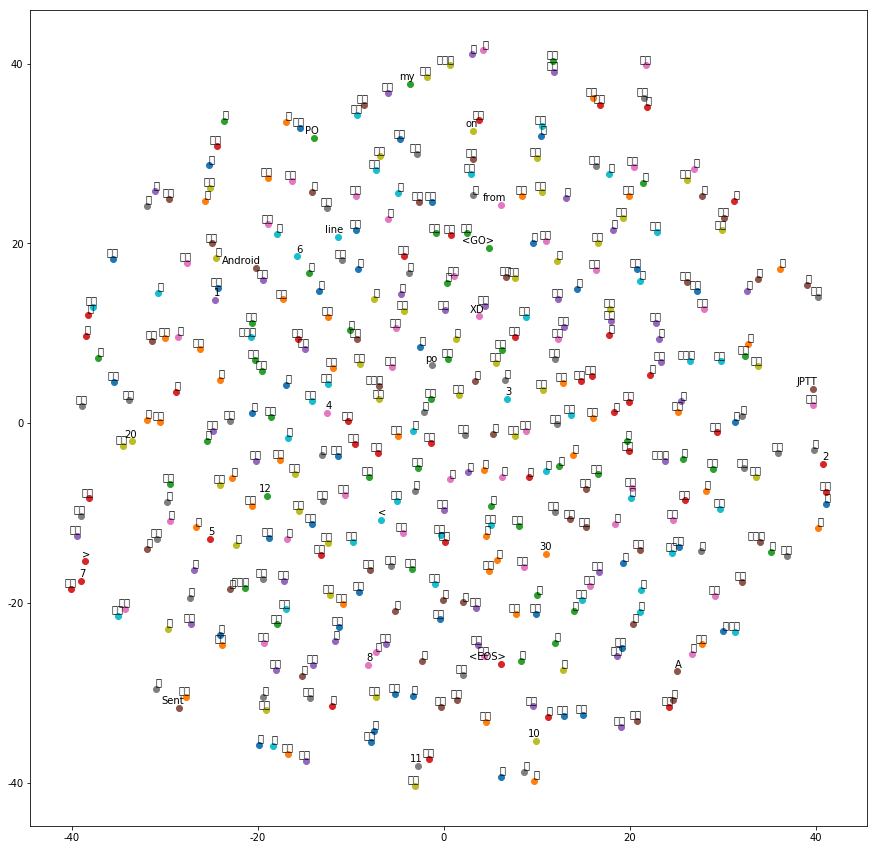

In [5]:
from matplotlib.font_manager import FontProperties 
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import pylab
from sklearn.manifold import TSNE

#font = FontProperties(fname= r'C:\windows\fonts\Microsoft JhengHei UI\msjh', size=10)
plt.rcParams['font.family']='msjh'#'Microsoft JhengHei UI' # 指定默認字體
plt.rcParams['axes.unicode_minus'] = False # 解決保存圖像是負號'-'顯示為方塊的問題

num_points = 400
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(normal_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [vocab_reverse[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)